## Libraries

`torchvision.datasets` contains some popular datasets for computer vision.

`torchvision.models` contains some popular architectures for computer vision.

`torchvision.transforms` contains common image transformations.

`torch.utils.data.Dataset` is an abstract class representing a dataset.

`torch.utils.data.DataLoader` wraps a dataset and provides access to the underlying data.

In [266]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


## import dataset

In [267]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

print(len(train_data))
print(len(test_data))

60000
10000


In [268]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [269]:
class_to_idx = train_data.class_to_idx
print(class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [270]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [271]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

## Visualizing data

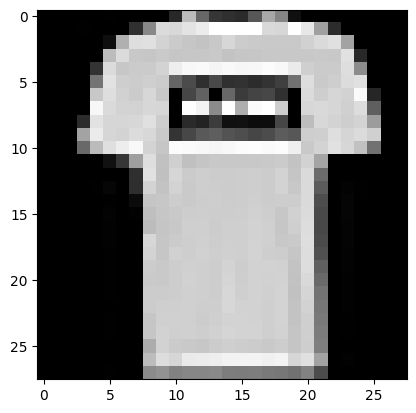

In [272]:
image, label = train_data[1]
plt.imshow(image.squeeze(), cmap="gray")

## Dataloaders

turns the data into an iterable object

In [273]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataloader), len(test_dataloader))

1875 313


In [274]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape, train_labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


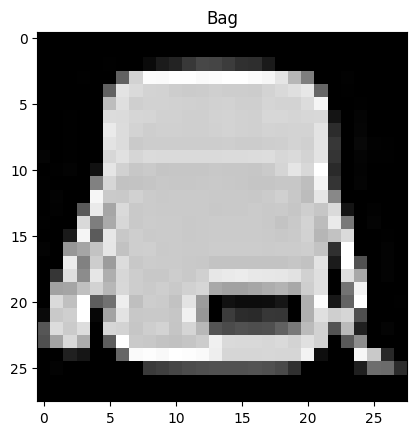

In [275]:
random_idx = torch.randint(0, len(train_features), (1,)).item()
img, label = train_features[random_idx], train_labels[random_idx]
plt.title(class_names[label]) 
plt.imshow(img.squeeze(), cmap="gray")

## Building the model

In [276]:
flatten_model = nn.Flatten()

x = train_features[0]

op = flatten_model(x)
op.shape

torch.Size([1, 784])

In [277]:
class CVModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

model = CVModel(28*28, 10, len(class_names))
model

CVModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Loss function, optimizer and evaluation metrics

In [278]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names))

In [279]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float):
    total_time = end - start
    print(f"Total Time: {total_time:.3f}s")
    return total_time


## Training Loop

In [280]:
from tqdm.auto import tqdm   # for progress bar

torch.manual_seed(42)
train_time_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)  # find average train_loss per batch for that particular epochs
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss +=  loss
            test_acc += accuracy(test_pred, y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\n Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}")

train_time_end = timer()

total_train_time = print_train_time(train_time_start, train_time_end)

 


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:04<00:16,  4.19s/it]


 Train Loss: 0.59 | Train Acc: 0.79 | Test Loss: 0.50 | Test Acc: 0.82
Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:08<00:13,  4.34s/it]


 Train Loss: 0.48 | Train Acc: 0.83 | Test Loss: 0.48 | Test Acc: 0.83
Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:12<00:08,  4.32s/it]


 Train Loss: 0.45 | Train Acc: 0.84 | Test Loss: 0.48 | Test Acc: 0.83
Epoch: 3
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:17<00:04,  4.31s/it]


 Train Loss: 0.44 | Train Acc: 0.85 | Test Loss: 0.46 | Test Acc: 0.84
Epoch: 4
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


 Train Loss: 0.44 | Train Acc: 0.85 | Test Loss: 0.47 | Test Acc: 0.83
Total Time: 21.283s


## Improving model

In [281]:
class CVModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
    
model_1 = CVModelV1(28*28, 10, len(class_names))
model_1


CVModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [282]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names))

loss_fn, optimizer, accuracy

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 MulticlassAccuracy())

In [283]:
from tqdm.auto import tqdm   # for progress bar

torch.manual_seed(42)
train_time_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_1.train()
        y_pred = model_1(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)  # find average train_loss per batch for that particular epochs
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_1(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_acc += accuracy(test_pred, y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\n Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}")

train_time_end = timer()

total_train_time = print_train_time(train_time_start, train_time_end)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:04<00:18,  4.51s/it]


 Train Loss: 1.10 | Train Acc: 0.62 | Test Loss: 0.77 | Test Acc: 0.72
Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:08<00:13,  4.48s/it]


 Train Loss: 0.72 | Train Acc: 0.74 | Test Loss: 0.74 | Test Acc: 0.74
Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:13<00:08,  4.29s/it]


 Train Loss: 0.67 | Train Acc: 0.75 | Test Loss: 0.69 | Test Acc: 0.75
Epoch: 3
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:17<00:04,  4.19s/it]


 Train Loss: 0.65 | Train Acc: 0.76 | Test Loss: 0.69 | Test Acc: 0.75
Epoch: 4
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


 Train Loss: 0.64 | Train Acc: 0.76 | Test Loss: 0.71 | Test Acc: 0.74
Total Time: 21.133s


## Functionizing training and testing loop

In [284]:
def train_step(model, optimizer, loss_fn, accuracy, train_dataloader):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy(y_pred, y) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    

In [285]:
def test_step(model, loss_fn, accuracy, test_dataloader):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in train_dataloader:
            # Send data to GPU
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy(y_pred, y) 
        # Adjust metrics and print out
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [286]:
torch.manual_seed(42)

epochs = 5

model_2 = CVModelV1(28*28, 10, len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names))

model_2, optimizer, loss_fn, accuracy

(CVModelV1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
   )
 ),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 CrossEntropyLoss(),
 MulticlassAccuracy())

In [287]:
train_time_start = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model_2, optimizer, loss_fn, accuracy, train_dataloader)
    test_step(model_2, loss_fn, accuracy, test_dataloader)

train_time_end = timer()
total_train_time = print_train_time(train_time_start, train_time_end)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 1.05878 | Train accuracy: 0.62%


 20%|██        | 1/5 [00:06<00:25,  6.45s/it]

Test loss: 5.77113 | Test accuracy: 0.62%

Epoch: 1
-----
Train loss: 0.91179 | Train accuracy: 0.66%


 40%|████      | 2/5 [00:12<00:19,  6.42s/it]

Test loss: 5.51609 | Test accuracy: 0.60%

Epoch: 2
-----
Train loss: 0.88172 | Train accuracy: 0.67%


 60%|██████    | 3/5 [00:19<00:12,  6.42s/it]

Test loss: 5.07840 | Test accuracy: 0.60%

Epoch: 3
-----
Train loss: 0.86017 | Train accuracy: 0.68%


 80%|████████  | 4/5 [00:26<00:06,  6.57s/it]

Test loss: 4.99192 | Test accuracy: 0.60%

Epoch: 4
-----
Train loss: 0.84860 | Train accuracy: 0.68%


100%|██████████| 5/5 [00:32<00:00,  6.52s/it]

Test loss: 4.94769 | Test accuracy: 0.61%

Total Time: 32.581s


In [293]:
torch.manual_seed(42)

epochs = 5

model_3 = CVModelV1(28*28, 10, len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names))

model_3, optimizer, loss_fn, accuracy

(CVModelV1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
   )
 ),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 CrossEntropyLoss(),
 MulticlassAccuracy())

In [294]:
from tqdm.auto import tqdm   # for progress bar

torch.manual_seed(42)
train_time_start = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_3.train()
        y_pred = model_3(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)  # find average train_loss per batch for that particular epochs
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_3.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_3(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_acc += accuracy(test_pred, y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\n Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}")

train_time_end = timer()

total_train_time = print_train_time(train_time_start, train_time_end)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:04<00:17,  4.28s/it]


 Train Loss: 1.09 | Train Acc: 0.61 | Test Loss: 0.96 | Test Acc: 0.65
Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:08<00:12,  4.25s/it]


 Train Loss: 0.78 | Train Acc: 0.72 | Test Loss: 0.72 | Test Acc: 0.74
Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:12<00:08,  4.25s/it]


 Train Loss: 0.67 | Train Acc: 0.76 | Test Loss: 0.69 | Test Acc: 0.75
Epoch: 3
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:16<00:04,  4.24s/it]


 Train Loss: 0.64 | Train Acc: 0.77 | Test Loss: 0.65 | Test Acc: 0.76
Epoch: 4
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


 Train Loss: 0.63 | Train Acc: 0.77 | Test Loss: 0.65 | Test Acc: 0.76
Total Time: 21.198s
